### Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
np.random.seed(42)



# from scipy.special import softmax

/Users/hokyungsung/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Neural model -- persistent activity

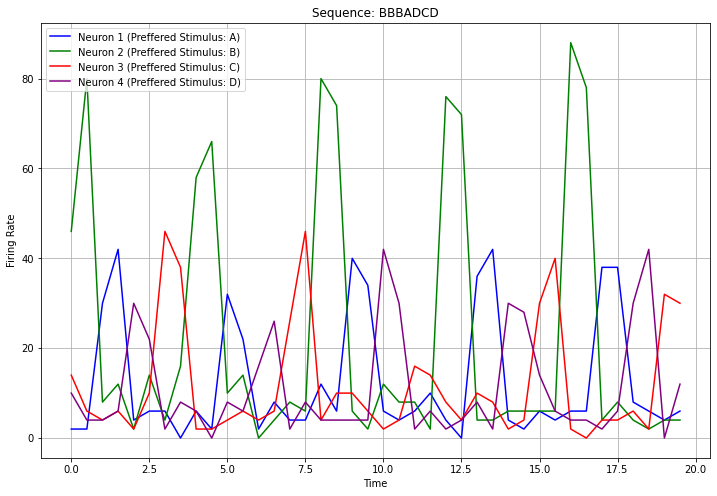

In [327]:
# Temporal model

import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
total_time = 20  # total time in seconds
dt = .05  # finer time step for Poisson generation
time = np.arange(0, total_time, dt)
n_neurons = 4
lambda_base = 5  # baseline firing rate (spikes/s)
lambda_active = 100  # maximum firing rate (spikes/s)
activation_period = 1  # time each neuron is active within a cycle (s)
cycle_length = 4  # length of one cycle (s)
bin_size = 0.5  # bin size for smoothing
num_bins = int(total_time / bin_size)

# Mapping of characters to neuron indices
activation_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

def adjust_sequence_for_repeats(sequence):
    """ Handles repeated characters and their counts directly for compression """
    result = []
    i = 0
    while i < len(sequence):
        count = 1
        while i + 1 < len(sequence) and sequence[i + 1] == sequence[i]:
            count += 1
            i += 1
        if count > 1:
            result.append(sequence[i] + str(count))
        else:
            result.append(sequence[i])
        i += 1
    return result  # Only use as many as there are populations

def sigmoid_firing_rate(character, count, lambda_base, lambda_active):
    """ Calculates firing rate based on the number of repeats using a sigmoid function. """
    k = 1.01  # Steepness of the curve
    x0 = 2  # Midpoint of the sigmoid
    lambda_max = lambda_active - lambda_base
    rate_increase = lambda_max / (1 + np.exp(-k * (count - x0)))
    return lambda_base + rate_increase

# Input sequence
input_sequence = "BBBADCD"
adjusted_sequence = adjust_sequence_for_repeats(input_sequence)
#print("Adjusted Sequence:", adjusted_sequence)

# Initialize spike counts array
spike_counts_updated = np.zeros((n_neurons, len(time)))

# Generate spikes for each neuron at each time point
for t_index, t in enumerate(time):
    cycle_index = int((t % cycle_length) // activation_period)
    if cycle_index < len(adjusted_sequence):
        current_char = adjusted_sequence[cycle_index]
        if len(current_char) == 2 and current_char[1].isdigit():
            char = current_char[0]
            repeat_count = int(current_char[1])
        else:
            char = current_char
            repeat_count = 1
        active_neuron = activation_mapping[char]
        for i in range(n_neurons):
            current_rate = sigmoid_firing_rate(char, repeat_count, lambda_base, lambda_active) if i == active_neuron else lambda_base
            spike_counts_updated[i, t_index] = np.random.poisson(current_rate * dt)

# Aggregate spikes into bins and calculate firing rates
firing_rates_final = np.zeros((n_neurons, num_bins))
for i in range(n_neurons):
    for b in range(num_bins):
        start_index = b * int(bin_size / dt)
        end_index = start_index + int(bin_size / dt)
        firing_rates_final[i, b] = np.sum(spike_counts_updated[i, start_index:end_index]) / bin_size

# Plotting
colors = ['blue', 'green', 'red', 'purple']  # Distinct colors for each neuron
time_bins_broad = np.arange(0, total_time, bin_size)
plt.figure(figsize=(12, 8))
for i in range(n_neurons):
    plt.plot(time_bins_broad, firing_rates_final[i], label=f'Neuron {i+1} (Preffered Stimulus: {"ABCD"[i]})', color=colors[i])
plt.title(f'Sequence: {input_sequence}')
plt.xlabel('Time')
plt.ylabel('Firing Rate')
plt.legend()
plt.grid(True)
plt.show()


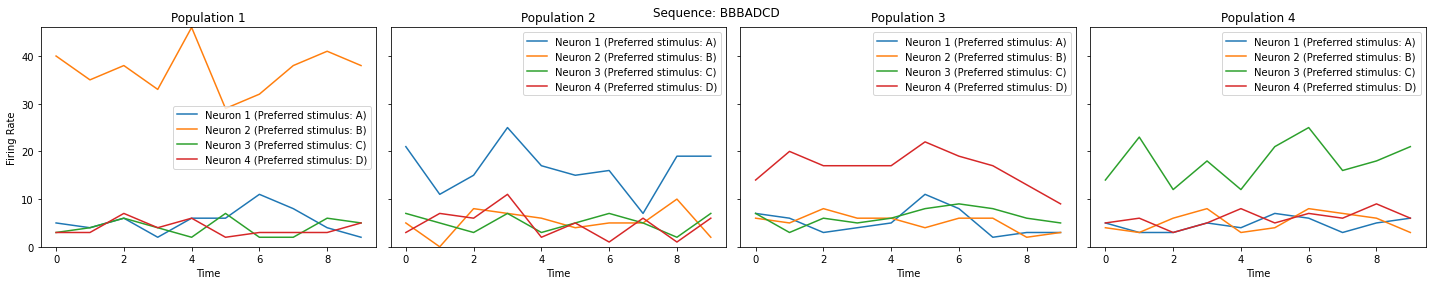

In [328]:
#Slot model

import numpy as np
import matplotlib.pyplot as plt

# Simulation settings
total_time = 10  # total time in seconds
dt = 1  # finer time step for Poisson generation
time = np.arange(0, total_time, dt)
num_populations = 4  # four populations
neurons_per_pop = 4  # four neurons per population (A, B, C, D)
lambda_base = 5  # baseline firing rate (spikes/s)
lambda_active = 50  # maximum firing rate (spikes/s)
bin_size = 1  # bin size for smoothing
num_bins = int(total_time / bin_size)

# Activation mapping for each letter to neuron index
activation_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

def adjust_sequence_for_repeats(sequence):
    """ Handles repeated characters and their counts directly for compression """
    result = []
    i = 0
    while i < len(sequence):
        count = 1
        while i + 1 < len(sequence) and sequence[i + 1] == sequence[i]:
            count += 1
            i += 1
        if count > 1:
            result.append(sequence[i] + str(count))
        else:
            result.append(sequence[i])
        i += 1
    return result[:num_populations]  # Only use as many as there are populations

def sigmoid_firing_rate(count, lambda_base, lambda_active):
    """ Calculates firing rate based on repeat count using a sigmoid function """
    k = 1  # Steepness of the curve
    x0 = 2  # Midpoint of the sigmoid
    lambda_max = lambda_active - lambda_base
    rate_increase = lambda_max / (1 + np.exp(-k * (count - x0)))
    return lambda_base + rate_increase

# Input sequence and adjust for repeats
input_sequence = "BBBADCD"
adjusted_sequence = adjust_sequence_for_repeats(input_sequence)
#print("Adjusted Sequence:", adjusted_sequence)

# Initialize spike counts array for all populations
spike_counts = np.zeros((num_populations, neurons_per_pop, len(time)))

# Generate spikes for each neuron in each population
np.random.seed(42)
for pop_index, seq_item in enumerate(adjusted_sequence):
    char = seq_item[0]
    repeat_count = int(seq_item[1]) if len(seq_item) > 1 else 1
    neuron_index = activation_mapping[char]
    for t_index, t in enumerate(time):
        for neuron in range(neurons_per_pop):
            current_rate = (sigmoid_firing_rate(repeat_count, lambda_base, lambda_active)
                            if neuron == neuron_index else lambda_base)
            spike_counts[pop_index, neuron, t_index] = np.random.poisson(current_rate * dt)

# Aggregate spikes into bins and calculate firing rates for plotting
firing_rates = np.zeros((num_populations, neurons_per_pop, num_bins))
for pop_index in range(num_populations):
    for neuron_index in range(neurons_per_pop):
        for b in range(num_bins):
            start_index = b * int(bin_size / dt)
            end_index = start_index + int(bin_size / dt)
            firing_rates[pop_index, neuron_index, b] = np.sum(spike_counts[pop_index, neuron_index, start_index:end_index]) / bin_size

# Plotting
time_bins = np.arange(0, total_time, bin_size)
fig, axs = plt.subplots(1, num_populations, figsize=(20, 4), sharey=True)  # Changed to one row, four columns
max_firing_rate = np.max(firing_rates)  # Determine the maximum firing rate for uniform scaling
for i in range(num_populations):
    for j in range(neurons_per_pop):
        axs[i].plot(time_bins, firing_rates[i, j, :], label=f'Neuron {j+1} (Preferred stimulus: {chr(65+j)})')
    axs[i].set_title(f'Population {i+1}')
    axs[i].legend()
    axs[i].set_ylim(0, max_firing_rate)  # Uniform y-axis scale
    axs[i].set_xlabel('Time')
axs[0].set_ylabel('Firing Rate')
plt.suptitle(f'Sequence: {input_sequence}')
plt.tight_layout()
plt.show()

### Neural model -- short-term weight modification

In [10]:
def one_hot_encode(sequence):
    if sequence == '':
        return np.zeros((1,4))

    # Mapping of characters to indices
    char_to_int = {'y': 0, 'r': 1, 'g': 2, 'b': 3}
    
    # Create an array of indices for each character in the sequence
    indices = np.array([char_to_int[char] for char in sequence])
    
    # Create the one-hot encoded array
    one_hot_encoded = np.zeros((len(sequence), len(char_to_int)), dtype=np.int32)
    one_hot_encoded[np.arange(len(sequence)), indices] = 1
    
    return one_hot_encoded

# Example usage
sequence = "rgby"
encoded_sequence = one_hot_encode(sequence)
print("Encoded Sequence:")
print(encoded_sequence)


def softmax(z, beta=1.0):
    # Shift by max to prevent overflow
    z_max = np.max(z)
    shifted_logits = z - z_max
    exp_shifted_logits = np.exp(shifted_logits / beta)
    softmax_output = exp_shifted_logits / np.sum(exp_shifted_logits)
    return softmax_output

Encoded Sequence:
[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]


In [11]:
# filters
def default(seq):
    return seq[-1]

def default2_all(seq):
    if seq.shape[0] < 2:
        return np.zeros(seq.shape[1]**2)

    # Convert each one-hot vector into a scalar index
    index1 = np.argmax(seq[-2])
    index2 = np.argmax(seq[-1])
    
    # Calculate the index in the resulting one-hot vector
    combined_index = index1 * 4 + index2
    
    output = np.zeros(seq.shape[1]**2)
    output[combined_index] = 1
    return output

def default2(seq):
    if seq.shape[0] < 2:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-2:], axis=0)
    return output

def default3(seq):
    if seq.shape[0] < 3:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-3:], axis=0)
    return output

def default4(seq):
    if seq.shape[0] < 4:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-4:], axis=0)
    return output

def repeat2(seq):
    if seq.shape[0] < 2:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-2:], axis=0)
    # Convert sums to 1 if they are 1, else to 0
    output = np.where(output == 2, 1, 0)
    return output

def repeat3(seq):
    if seq.shape[0] < 3:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-3:], axis=0)
    # Convert sums to 1 if they are 1, else to 0
    output = np.where(output == 3, 1, 0)
    return output

def repeat4(seq):
    if seq.shape[0] < 4:
        return np.zeros_like(seq[-1])

    output = np.sum(seq[-4:], axis=0)
    # Convert sums to 1 if they are 1, else to 0
    output = np.where(output == 4, 1, 0)
    return output

In [197]:
class DefaultContext():
    def __init__(self, context_idx, filter, num_features, alpha=0.3):
        self.num_actions = 4            # corresponding to possible action
        self.context_idx = context_idx
        self.filter = filter
        self.num_features = num_features
        self.seen_contexts = []
        self.weights = self.initialize_weights()
        self.alpha = alpha

    def get_context_vector(self, seq):
        context_vector = self.filter(seq)
        seen = self.check_seen(context_vector)
        return context_vector, seen

    def check_seen(self, context_vector):
        if list(context_vector) in self.seen_contexts:
            return True
        else:
            self.seen_contexts += [list(context_vector)]
            return False
        
    def predict(self, seq):
        state_vector, seen = self.get_context_vector(seq)
        pred = softmax(state_vector @ self.weights)
        choice = np.argmax(pred)
        # choice = np.random.choice(np.arange(num_classes), p=pred_dist)
        return pred, state_vector, seen, choice
    
    def initialize_weights(self):
        return np.random.normal(0, 0.1,
                                size=(self.num_features, self.num_actions)) + 1
    
    def update_weights(self, seq, target):
        pred, state_vector, seen, _ = self.predict(seq)
        new_weights = self.weights
        new_pred = pred

        count = 0
        while np.argmax(new_pred) != np.argmax(target):
            # If the particular state has been seen before, break
            if seen:
                return False
            
            # weights is a matrix of size (num_features, num_classes)
            update = np.outer(state_vector, (target - new_pred))
            new_weights = new_weights + self.alpha*update
            new_pred = softmax(state_vector @ new_weights)
            
        self.weights = new_weights
        return True

class RepeatContext(DefaultContext):
    def __init__(self, context_idx, filter, num_features, alpha=0.3):
        self.num_actions = 4            # corresponding to possible action
        self.context_idx = context_idx
        self.filter = filter
        self.num_features = num_features
        self.seen_contexts = []
        self.weights = self.initialize_weights()
        self.alpha = alpha
        
    def predict(self, seq):
        state_vector = seq[-1]
        pred = state_vector
        seen = False
        choice = np.argmax(seq[-1])
        return pred, state_vector, seen, choice

In [305]:
def simulate_trial(seq, filters, max_complexity=4):
    chars = 'yrgb'
    num_classes = len(chars)
    # start with first default context, assume at least one filter
    current_complexity = 0
    context_id = 0
    contexts = dict()
    context_change_indices = []
    repeat_context_indices = []
    contexts['repeat'] = RepeatContext('r', repeat2, num_classes)
    contexts[context_id] = DefaultContext(context_id, filters[context_id],
                                          num_classes)
    # currently assume len(chars) number of features for each context
    current_context = contexts[context_id]
    correct = True
    accs = [correct]
    
    for i in range(1, len(seq)):
        # "already seen" subsequence for trial
        subseq = seq[:i]
        
        # generate prediction
        subseq_onehot = one_hot_encode(subseq)
        
        # observe new item, which is the action that should be taken next
        target = one_hot_encode(seq[i])[0]

        # ENCODING PHASE: update weights to predict target
        if np.argmax(subseq_onehot[-1]) == np.argmax(target):
            # if the last item in the sequence is the target,
            # add to repeat context
            repeat_context_indices += [i]
            if i - 1 not in repeat_context_indices:
                current_complexity += 0.25
        else:
            # move back to last default context if not repeat
            if not current_context.update_weights(subseq_onehot, target):
                # if the current context did not predict the target, and
                # the state within the context has been seen before, then
                # move to the next context
                context_change_indices += [i]
                context_id += 1
                current_complexity += 1
                if current_complexity < max_complexity:
                    contexts[context_id] = DefaultContext(context_id,
                                                filters[context_id],
                                                len(chars))
                    current_context = contexts[context_id]
                    current_context.update_weights(subseq_onehot, target)

        # RESPONSE PHASE: generate response "predictions"
        response = subseq[0]
        response_context_id = 0
        current_context = contexts[response_context_id]
        for j in range(1, i+1):
            if j in context_change_indices:
                response_context_id += 1
            if j in repeat_context_indices:
                current_context = contexts['repeat']
            elif current_complexity < max_complexity:
                if np.random.binomial(1, current_complexity/max_complexity):
                    current_context = contexts[np.random.randint(0,
                                                        len(contexts)-1)]
                else:
                    current_context = contexts[response_context_id]
                    
            subseq_onehot = one_hot_encode(subseq[:j])
            _, _, _, choice = current_context.predict(subseq_onehot)
            response += chars[choice]
            if current_context == contexts['repeat']:
                try:
                    current_context = contexts[context_id]
                except:
                    current_context = contexts[0]

        target = seq[:i+1]
        # only correct if got previous sequence correct too
        correct = correct and (target == response)
        accs += [correct]
    return response, accs

In [306]:
chars = 'yrgb'
max_complexity = 3
filters = [default] * max_complexity
# test = 'bybrgbbrrrr'
# test = 'yrgbygrbyy'
# test = 'brgbrgbrrrrrr'

test = 'rrbrrgyrrryrgbbbrbybgybry'

response, accs = simulate_trial(test, filters, max_complexity=max_complexity)
score = np.sum(accs)
print(response)
print(score)

rrbrrbygrrbgbybbrbrgrygrb
9


In [304]:
# test on randomly generated sequences
responses = []
seqs = []
scores = []
for _ in range(100):
    seq_indices = np.random.choice(np.arange(4), 25)
    seq = [chars[i] for i in seq_indices]
    seq = ''.join(seq)
    seqs += [seq]
    response, accs = simulate_trial(seq, filters, max_complexity=max_complexity)
    responses += [response]
    score = np.sum(accs)
    scores += [score]

print(np.array(scores))
sorted_seqs = np.array(seqs)[np.argsort(scores)]
print(np.array(scores)[np.argsort(scores)])
print(sorted_seqs[:5])
print(sorted_seqs[-5:])
print()
print("min score", np.min(scores))
print(np.array(seqs)[np.array(scores) == np.min(scores)])
print("max score", np.max(scores))
print(np.array(seqs)[np.array(scores) == np.max(scores)])

[18 14 17 18 14 13 13 14 10 15 17 14 14 16  8 11 15 11 17 16 16 12 16 14
 13 12 18 17 11 16 15 17 13 11 16 16 13 13 15 14 11 12 15 14 12 15 10 13
 16 14 13 11 18 13 12 12 15 18 14 14 14 16 18 14 15  9 11 14 10 17 14 14
 17 16 12 17 16 21 16 12 12 16 13 17 12 15 11 13 17 14 18 13 14 13 13 22
 14 18 17 14]
[ 8  9 10 10 10 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16
 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18
 18 18 21 22]
['grgygrgryryrbrrggbyyyryrb' 'rgrbyrybrggyygbrryrrgybgg'
 'yggyryrgbgyrrgbrgygbrbygr' 'bbgbrrbybbgyrbbbyrrgyybbb'
 'yrygbbybyyryyrgbgbrbbyygy']
['rrrryggbryryyryrrrgygrygb' 'rgbrrrrrrrrgyygbbggbryggr'
 'byrgbyrrgbyggbggbrryyyrbb' 'ygrbrbryyygbbyyyryryrrryr'
 'rgrgrbybbbbbbyrbggyyyybgy']

min score 8
['grgygrgryryrbrrggbyyyryrb']
max score 22
['rgrgrbybbbbbbyrbggyyyybgy']


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3569eb68-a6a6-4122-9c3d-498e88f49235' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>